In [62]:
import pymonntorch

In [63]:
pymonntorch.__version__

'0.1.4'

In [64]:
net = pymonntorch.Network()

In [65]:
net.initialize()

Network['Network_1', 'Network'](Neurons: tensor(0.)|0 groups, Synapses: tensor(0.)|0 groups){}


In [66]:
net.simulate_iterations(1000)

1000xBatch: 1/1 (100%) 8.019ms


8.019208908081055

In [67]:
from pymonntorch import *
import torch
from matplotlib import pyplot as plt
import random
from PIL import Image

# Current

In [68]:
class SetCurrent(Behavior):
	def initialize(self, ng):
		self.offset = self.parameter("value")
		ng.I = ng.vector(mode = self.offset)

	def forward(self, ng):
		ng.I.fill_(self.offset)


class StepFunction(Behavior):
	def initialize(self, ng):
		self.value = self.parameter("value")
		self.t0 = self.parameter("t0")

	def forward(self, ng):
		if ng.network.iteration * ng.network.dt >= self.t0:
			ng.I += ng.vector(mode=self.value) * ng.network.dt


class SinFunc(Behavior) :
    def initialize(self, ng):
        self.value = self.parameter("value", 10)

    def forward(self, ng):
        ng.I = ng.vector(mode = self.value) * np.sin(ng.network.iteration/180 * np.pi)**2 * ng.network.dt


# class NoiseFun(Behavior) :
#     def initialize(self, ng):
#         self.value = self.parameter("value", 10)

#     def forward(self, ng):
#         ng.I = (ng.vector(mode = self.value) * ng.network.dt + ((random.random() * self.value - self.value/2)))

class NoiseFun(Behavior):
	def initialize(self, ng):
		self.value = self.parameter("value", 10)
		self.t0 = self.parameter("t0", 50)
		
	def forward(self, ng):
		if ng.network.iteration * ng.network.dt >= self.t0:
			ng.I = (ng.vector(mode = self.value) * ng.network.dt + ((random.random() * self.value - self.value/2)))

# dt

In [69]:
class TimeResolution(Behavior):
	def initialize(self, network):
		network.dt = self.parameter("dt", 1.0)

# Synapse

In [70]:
class SynFun(Behavior):
	def initialize(self, sg):
		sg.c = sg.matrix("zeros")
		sg.I = sg.dst.vector()

	def forward(self, sg):
		sg.I = torch.sum(sg.W[sg.src.spike == 1], axis=0)

class InpSyn(Behavior):
	def initialize(self,ng) : 
		ng.I = ng.vector()

	def forward(self, ng):
		ng.I *= 0.4
		for syn in ng.afferent_synapses["All"]:
			ng.I += syn.I

# LIF Behavior

In [71]:
class LIF(Behavior):
	def initialize(self, ng):
		self.tau = self.parameter("tau")
		self.u_rest = self.parameter("u_rest")
		self.u_reset = self.parameter("u_reset")
		self.threshold = self.parameter("threshold")
		self.R = self.parameter("R")

		k = self.parameter("v_init", default="normal(0.3, 0.05)")

		# ng.threshold = ng.vector(mode='init_threshold')
		ng.v = ng.vector(mode=k)
		ng.spike = ng.v >= self.threshold
		ng.v[ng.spike] = self.u_reset
		ng.A = ng.vector(torch.sum(ng.spike).item() / ng.size)


	def forward(self, ng):
		
		# firing
		ng.spike = ng.v >= self.threshold

		#reset
		ng.v[ng.spike] = self.u_reset
		
		# dynamic
		leakage = -(ng.v - self.u_rest)
		currents = self.R * ng.I
		ng.v += (leakage + currents) / self.tau * ng.network.dt

		ng.A = ng.vector(torch.sum(ng.spike).item() / ng.size)

# Connectivity scheme

In [72]:
class Full(Behavior):
	def initialize(self, sg):
		self.J_0 = self.parameter("J_0", 1000)

		# if(self.J_0 == 1) : 
		# 	sg.W = sg.matrix("zeros")
		# 	return
		self.N = sg.dst.size
		sg.W = sg.matrix("normal({}, {})".format(self.J_0 / self.N, (self.J_0 / self.N) / 2))
		

# Image reading

In [73]:
bird = Image.open("p3_image/bird.tif")

In [74]:
bird_image=np.array(Image.open("p3_image/bird.tif"))

In [75]:
print(bird_image)

[[186 184 187 ... 169 166 166]
 [183 184 186 ... 170 168 168]
 [186 186 187 ... 169 168 168]
 ...
 [142 144 147 ...  70  68  68]
 [147 147 147 ...  75  75  75]
 [147 145 144 ...  75  75  75]]


In [76]:
print(bird_image.shape)

(256, 256)


In [77]:
resized_bird=bird.resize((25, 25))
resized_bird

In [78]:
resized_bird_np = np.array(resized_bird)

In [79]:
resized_bird_np

array([[188, 193, 189, 184, 181, 178, 176, 175, 173, 170, 169, 167, 166,
        164, 162, 160, 156, 155, 157, 153, 156, 159, 160, 163, 166],
       [186, 191, 187, 183, 179, 176, 175, 173, 172, 170, 168, 167, 165,
        163, 161, 158, 156, 154, 146, 137, 153, 154, 155, 159, 161],
       [182, 186, 182, 180, 177, 174, 172, 171, 169, 168, 165, 163, 162,
        160, 157, 155, 149, 135, 125, 145, 149, 148, 149, 153, 155],
       [178, 181, 178, 176, 175, 172, 169, 167, 165, 165, 168, 179, 183,
        167, 138, 131, 127, 130, 144, 145, 143, 144, 145, 147, 150],
       [174, 178, 175, 173, 172, 170, 167, 165, 163, 145, 180, 206, 202,
        182, 151, 130, 146, 147, 143, 142, 140, 141, 142, 144, 146],
       [172, 175, 172, 170, 170, 168, 166, 164, 157, 109, 130, 145,  91,
        177, 187, 181, 158, 145, 141, 140, 139, 139, 139, 141, 141],
       [169, 172, 169, 168, 167, 166, 164, 164, 132, 107, 143, 114, 132,
        155, 139, 160, 175, 132, 141, 137, 136, 136, 135, 136, 137],
      

In [80]:
resized_bird_np.shape

(25, 25)

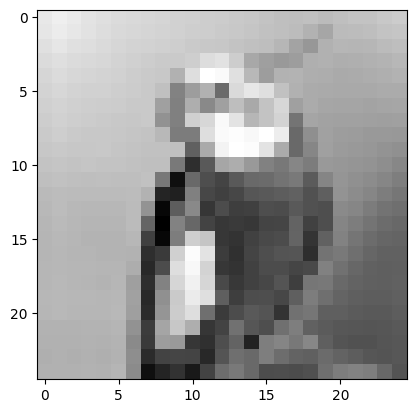

In [81]:
plt.imshow(resized_bird_np, cmap="gray")

In [82]:
flattened_bird = resized_bird_np.flatten()

In [83]:
flattened_bird.shape

(625,)

In [84]:
class TTFS(Behavior):
    def initialize(self, ng):
        self.input = self.parameter("input")
        self.interval = self.parameter("interval")
        ng.spike = ng.vector("zeros")

    def forward(self, ng):
        i = ng.network.iteration
        start = (256/self.interval) * (i-1)
        stop = (256/self.interval) * (i)

        ng.spike = ng.vector("zeros")
        ng.spike[torch.logical_and(start <= self.input , self.input<=stop)] = 1

Images

In [85]:
bird = Image.open("p3_image/bird.tif")
resized_bird = bird.resize((25, 25))
resized_bird_np = np.array(resized_bird)
flattened_bird = resized_bird_np.flatten()
torch_flattened_bird = torch.from_numpy(flattened_bird)

circles = Image.open("p3_image/circles.tif")
resized_circles = circles.resize((25, 25))
resized_circles_np = np.array(resized_circles)
flattened_circles = resized_circles_np.flatten()
torch_flattened_circles = torch.from_numpy(flattened_circles)

camera = Image.open("p3_image/camera.tif")
resized_camera = camera.resize((25, 25))
resized_camera_np = np.array(resized_camera)
flattened_camera = resized_camera_np.flatten()
torch_flattened_camera = torch.from_numpy(flattened_camera)

horiz = Image.open("p3_image/horiz.tif")
resized_horiz = horiz.resize((25, 25))
resized_horiz_np = np.array(resized_horiz)
flattened_horiz = resized_horiz_np.flatten()
torch_flattened_horiz = torch.from_numpy(flattened_horiz)

In [86]:
resized_bird

Network['Network_1', 'Network'](Neurons: tensor(625)|1 groups, Synapses: tensor(0.)|0 groups){1:TimeResolution()}
NeuronGroup['NG1', 'NeuronGroup', 'ng'](625){2:TTFS(input=tensor([188, 193, 189, 184, 181, 178, 176, 175, 173, 170, 169, 167, 166, 164,
        162, 160, 156, 155, 157, 153, 156, 159, 160, 163, 166, 186, 191, 187,
        183, 179, 176, 175, 173, 172, 170, 168, 167, 165, 163, 161, 158, 156,
        154, 146, 137, 153, 154, 155, 159, 161, 182, 186, 182, 180, 177, 174,
        172, 171, 169, 168, 165, 163, 162, 160, 157, 155, 149, 135, 125, 145,
        149, 148, 149, 153, 155, 178, 181, 178, 176, 175, 172, 169, 167, 165,
        165, 168, 179, 183, 167, 138, 131, 127, 130, 144, 145, 143, 144, 145,
        147, 150, 174, 178, 175, 173, 172, 170, 167, 165, 163, 145, 180, 206,
        202, 182, 151, 130, 146, 147, 143, 142, 140, 141, 142, 144, 146, 172,
        175, 172, 170, 170, 168, 166, 164, 157, 109, 130, 145,  91, 177, 187,
        181, 158, 145, 141, 140, 139, 139, 139, 

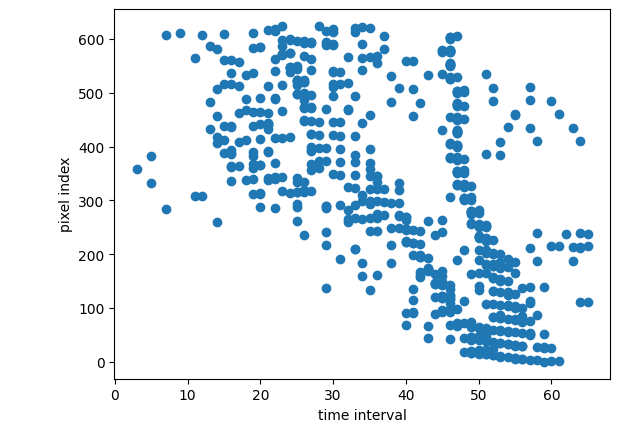

In [87]:
net1 = Network(behavior={1: TimeResolution()}, dtype=torch.float64)

ng1 = NeuronGroup(
    625,
    net = net1, 
    behavior={ 2 : TTFS(input=torch_flattened_bird, interval=80),
               3 : EventRecorder(["spike"], tag="ng1_evrec"),
               },
               tag="NG1",
)

net1.initialize()

net1.simulate_iterations(100)

plt.scatter(net1["spike", 0][:,0], net1["spike", 0][:,1])
plt.xlabel("time interval")
plt.ylabel("\n\n\npixel index")
plt.show()

# Numerical value

In [88]:
class NV(Behavior):
    def initialize(self, ng):
        self.input = self.parameter("input")
        self.duration = self.parameter("duration")
        ng.spike = ng.vector("zeros")
        self.sigma = self.parameter("sigma", 2)
        ng.spike_time = ng.vector("zeros")

        for i in range(ng.size):
            ng.spike_time[i] = self.duration - int(self.dist(self.sigma, i ,self.input) / self.dist(self.sigma, 1, 1) * self.duration)

    def dist(self, sigma, mu, x):
        return 1/(sigma*np.sqrt(2*np.pi))*np.exp(-(x-mu)**2/(2*sigma**2))
    
    def forward(self, ng):
        ng.spike = ng.vector("zeros")
        ng.spike[ng.network.iteration == ng.spike_time] = 1

Network['Network_1', 'Network'](Neurons: tensor(400)|1 groups, Synapses: tensor(0.)|0 groups){1:TimeResolution()}
NeuronGroup['NG1', 'NeuronGroup', 'ng'](400){2:NV(input=155.6,duration=30,sigma=50,)3:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=ng1_evrec,arg_0=['spike'],)}
100xBatch: 1/1 (100%) 15.972ms


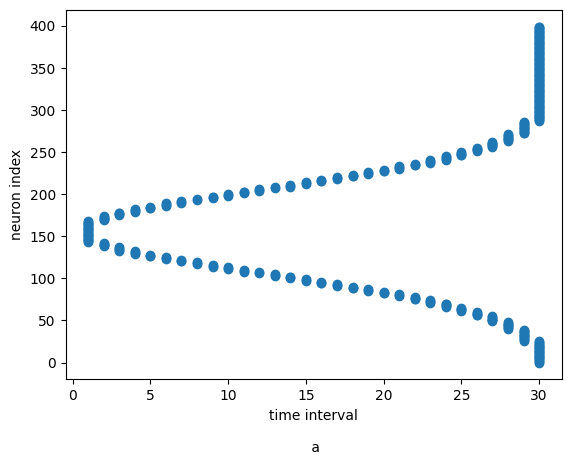

In [89]:
net1 = Network(behavior={1: TimeResolution()}, dtype=torch.float64)

ng1 = NeuronGroup(
    400,
    net = net1, 
    behavior={ 2 : NV(input= 155.6, duration=30, sigma = 50),
               3 : EventRecorder(["spike"], tag="ng1_evrec"),
               },
               tag="NG1",
)

net1.initialize()

net1.simulate_iterations(100)

plt.scatter(net1["spike", 0][:,0], net1["spike", 0][:,1])
plt.xlabel("time interval\n \n a")
plt.ylabel("neuron index")
plt.show()

# Poisson

In [90]:
class Poisson(Behavior):
    def initialize(self, ng):
        self.input = self.parameter("input")
        self.landa = self.parameter("landa")
        ng.spike = ng.vector("zeros")
        
        self.input = torch.floor(self.input / 255 * 30)
        self.landa = int(self.landa / 255 * 30)

    def p_dist(self, landa, k):
        prob = ((landa**int(k))*np.exp(-landa))/np.math.factorial(int(k))
        return prob
        

    def forward(self, ng):
        ng.spike = ng.vector("zeros")
        for i in range(0, ng.size):
            ng.spike[i] = self.p_dist(self.landa, self.input[i].item())/10 >= torch.rand(1)

In [91]:
class PoissonGenerator(Behavior):
    def initialize(self, ng):
        # self.input = self.parameter("input")
        self.landa = self.parameter("landa", 20)
        self.duration = self.parameter("duration", 40)
        ng.spike = ng.vector("zeros")

    def p_dist(self, landa, k):
        prob = ((landa**int(k))*np.exp(-landa))/np.math.factorial(int(k))
        return prob
        

    def forward(self, ng):
        ng.spike = ng.vector("zeros")
        for i in range(0, ng.size):
            ng.spike[i] = self.p_dist(self.landa, ng.network.iteration)*8 >= torch.rand(1)

In [92]:
a = torch.tensor([1, 2.4])
torch.floor(a)

tensor([1., 2.])

In [93]:
torch_flattened_bird = torch.from_numpy(flattened_bird)

In [94]:
resized_horiz

Network['Network_1', 'Network'](Neurons: tensor(625)|1 groups, Synapses: tensor(0.)|0 groups){1:TimeResolution()}
NeuronGroup['NG1', 'NeuronGroup', 'ng'](625){2:PoissonGenerator(landa=40,)3:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=ng1_evrec,arg_0=['spike'],)}


C:\Users\USER\AppData\Local\Temp\ipykernel_24412\106167534.py:9: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  prob = ((landa**int(k))*np.exp(-landa))/np.math.factorial(int(k))


100xBatch: 1/1 (100%) 2076.229ms


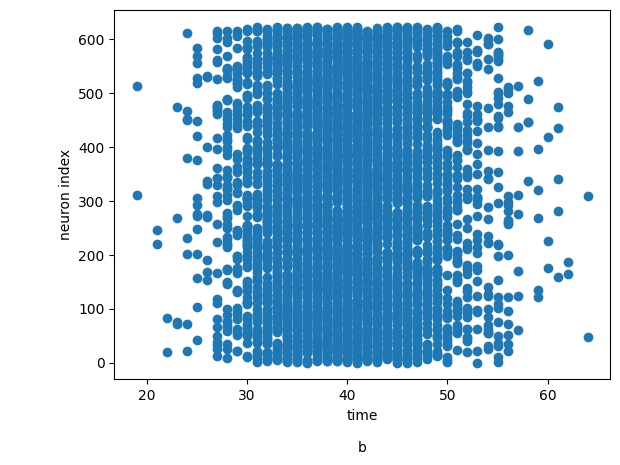

In [95]:
net1 = Network(behavior={1: TimeResolution()}, dtype=torch.float64)

ng1 = NeuronGroup(
    625,
    net = net1, 
    behavior={ 
        # 2 : Poisson(input=torch_flattened_horiz, landa=150), 
        2 : PoissonGenerator(landa = 40),
        3 : EventRecorder(["spike"], tag="ng1_evrec"),
    },
    tag="NG1",
)

net1.initialize()

net1.simulate_iterations(100)

plt.scatter(net1["spike", 0][:,0], net1["spike", 0][:,1])
plt.xlabel("time\n\nb")
plt.ylabel("\n\n\nneuron index")
plt.show()

# STDP

In [96]:
class Trace(Behavior):
    def initialize(self, ng):
        self.tau = self.parameter("tau")
        ng.pre_trace = ng.vector("zeros")
        ng.post_trace = ng.vector("zeros")

    def forward(self, ng):
        dx_pre = -(ng.pre_trace/self.tau) + ng.spike
        dx_post = -(ng.post_trace/self.tau) + ng.spike

        ng.pre_trace += dx_pre * ng.network.dt
        ng.post_trace += dx_post * ng.network.dt

In [97]:
class STDP(Behavior):
    def initialize(self, ng):
        self.A = self.parameter("A")

    def forward(self, ng):
        for syn in ng.afferent_synapses["All"]:
            delta_w = (-self.A * syn.dst.post_trace * syn.src.spike[: , None] + self.A * syn.src.pre_trace[: , None] * syn.dst.spike)*ng.network.dt
            syn.W = torch.clip(syn.W + delta_w, 0.0, 200.0) # 0.0 = min w, 100.0 = max w

Network['Network_1', 'Network'](Neurons: tensor(10)|2 groups, Synapses: tensor(16)|1 groups){1:TimeResolution()}
NeuronGroup['NG_IN', 'NeuronGroup', 'ng'](8){2:PoissonGenerator(landa=30,duration=60,)6:Trace(tau=10,)9:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=ng_in_evrec,arg_0=['spike'],)}
NeuronGroup['NG_OUT', 'NeuronGroup', 'ng'](2){4:InpSyn()5:LIF(tau=10,u_rest=-65,u_reset=-73,threshold=-10,R=1,v_init=normal(-40, 10),)6:Trace(tau=10,)7:STDP(A=10,)9:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=ng_out_evrec,arg_0=['spike'],)}
SynapseGroup['SynapseGroup_1', 'SynapseGroup', 'syn', 'NG_IN => NG_OUT'](S8xD2){2:Full(J_0=1000,),3:SynFun(),9:Recorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['W'],),}
100xBatch: 1/1 (100%) 128.042ms


C:\Users\USER\AppData\Local\Temp\ipykernel_24412\106167534.py:9: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  prob = ((landa**int(k))*np.exp(-landa))/np.math.factorial(int(k))


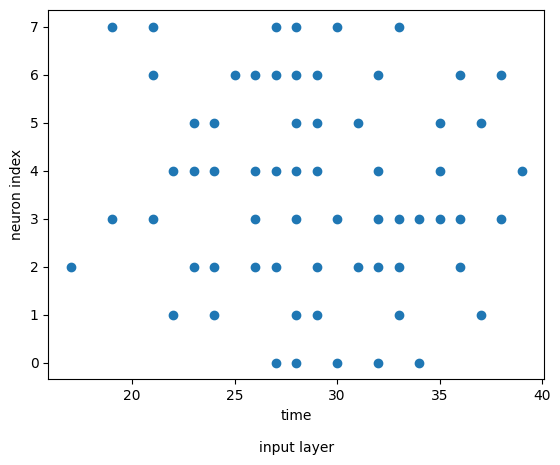

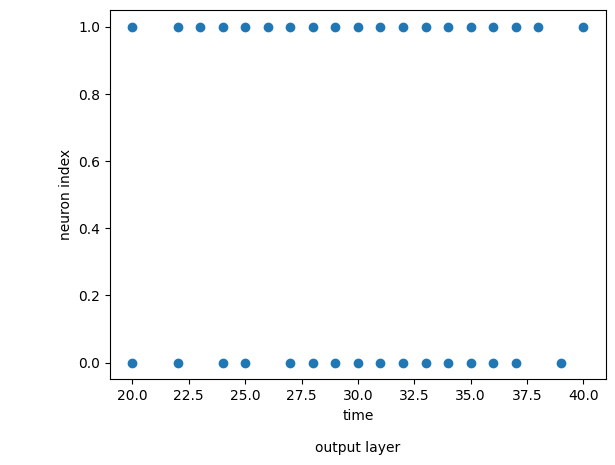

In [98]:
net1 = Network(behavior={1: TimeResolution()}, dtype=torch.float64)

ng_input = NeuronGroup(
    8,
    net = net1, 
    behavior={ 2 : PoissonGenerator(landa = 30, duration = 60),
              
                6 : Trace(tau = 10),
                9 : EventRecorder(["spike"], tag="ng_in_evrec"),
                },
                tag="NG_IN",
)

ng_output = NeuronGroup(
    2,
    net = net1, 
    behavior={  4 : InpSyn(),
                5 : LIF(
                    tau=10,
                    u_rest=-65,
                    u_reset=-73,
                    threshold=-10,
                    R=1,
                    v_init="normal(-40, 10)",
                ),
                6 : Trace(tau = 10),
                7 : STDP(A=10),
                9 : EventRecorder(["spike"], tag="ng_out_evrec"),
                },
                tag="NG_OUT",

)

Syn1 = SynapseGroup(net=net1, src=ng_input, dst=ng_output, behavior={
                2: Full(J_0=1000),
                3: SynFun(),
                9: Recorder(["W"]),
            })

net1.initialize()

net1.simulate_iterations(100)

plt.scatter(ng_input["spike", 0][:,0], ng_input["spike", 0][:,1])
plt.xlabel("time\n\ninput layer")
plt.ylabel("neuron index")
plt.show()

plt.scatter(ng_output["spike", 0][:,0], ng_output["spike", 0][:,1])
plt.xlabel("time\n\noutput layer")
plt.ylabel("\n\n\nneuron index")
plt.show()

Text(0.5, 0, '\ncosine similarity of the synaptic weights for output neurons')

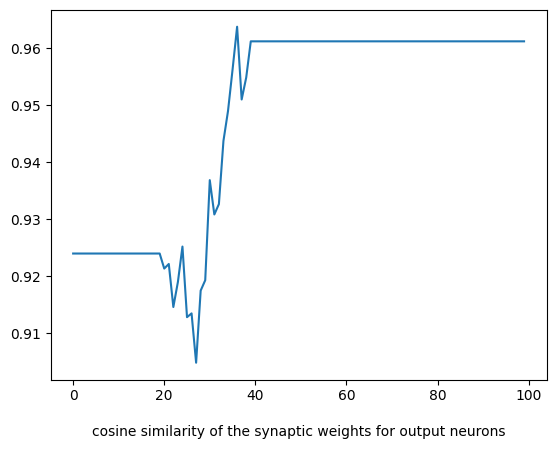

In [99]:
A = Syn1["W", 0][:,:,0]

B = Syn1["W", 0][:,:,1]


plt.plot(torch.nn.functional.cosine_similarity(A, B, dim = 1))
plt.xlabel("\ncosine similarity of the synaptic weights for output neurons")

<function matplotlib.pyplot.show(close=None, block=None)>

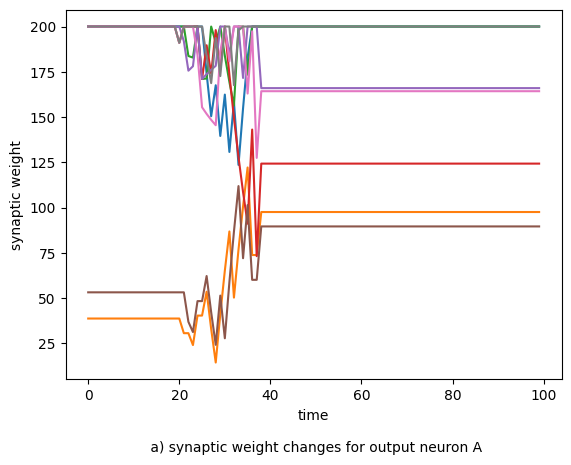

In [100]:
plt.plot(A)
plt.xlabel("time\n\n a) synaptic weight changes for output neuron A")
plt.ylabel("synaptic weight")
plt.show
# plt.plot(B)
# plt.show

# Multi Poisson generator

In [101]:
class PoissonGenerator(Behavior):
    def initialize(self, ng):
        ng.spike = ng.vector("zeros")
        self.offset = self.parameter("offset")
        self.duration = self.parameter("duration")
        self.landa = self.parameter("landa")

    def p_dist(self, landa, k):
        prob = ((landa**int(k))*np.exp(-landa))/np.math.factorial(int(k))
        return prob

    def find_pattern(self, ng):
        #print(self.offset)
        for i in range(0, len(self.offset)):
            if ng.network.iteration >= self.offset[i] and ng.network.iteration <= self.offset[i] + self.duration[i] :
                return i
        return -1
         

    def forward(self, ng):
        # ng.spike = ng.vector("zeros")
        index = self.find_pattern(ng)
        for i in range(0, ng.size):
            if index == -1:
                #print("Ah : ", ng.network.iteration)
                ng.spike = ng.vector("zeros")
                break
            else:
                ng.spike[i] = self.p_dist(self.landa[index], ng.network.iteration-self.offset[index])*10 >= torch.rand(1)


In [102]:
class BackAct(Behavior) : 

    def initialize(self, ng) : 
        self.spike_prob = self.parameter("spike_prob", 0.2)

    def forward(self, ng) : 
        randnum = torch.rand(ng.size)
        ng.spike[randnum <= self.spike_prob] = 1

Network['Network_1', 'Network'](Neurons: tensor(10)|3 groups, Synapses: tensor(16)|2 groups){1:TimeResolution()}
NeuronGroup['NG_IN1', 'NeuronGroup', 'ng'](4){2:PoissonGenerator(landa=[20],duration=[40],offset=[10],)5:BackAct(spike_prob=0.02,)6:Trace(tau=10,)9:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=ng_in_evrec,arg_0=['spike'],)}
NeuronGroup['NG_IN2', 'NeuronGroup', 'ng'](4){2:PoissonGenerator(landa=[30],duration=[40],offset=[50],)5:BackAct(spike_prob=0.02,)6:Trace(tau=10,)9:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=ng_in_evrec,arg_0=['spike'],)}
NeuronGroup['NG_OUT', 'NeuronGroup', 'ng'](2){3:InpSyn()4:LIF(tau=10,u_rest=-65,u_reset=-73,threshold=-10,R=1,v_init=normal(-40, 10),)5:BackAct(spike_prob=0.02,)6:Trace(tau=10,)7:STDP(A=10,)9:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=ng_out_evrec,arg_0=['spike'],)}
SynapseGroup['SynapseGroup_1', 'SynapseGroup', 'syn', 'NG_IN1 => 

C:\Users\USER\AppData\Local\Temp\ipykernel_24412\1563923190.py:9: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  prob = ((landa**int(k))*np.exp(-landa))/np.math.factorial(int(k))


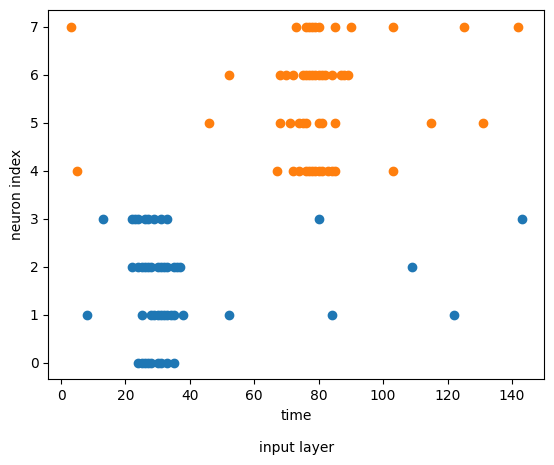

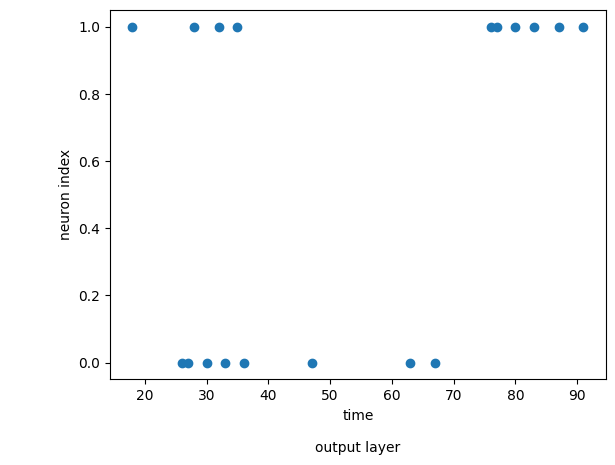

In [103]:
net1 = Network(behavior={1: TimeResolution()}, dtype=torch.float64)

ng_input1 = NeuronGroup(
    4,
    net = net1, 
    behavior={ 2 : PoissonGenerator(landa = [20], duration = [40], offset= [10]),
              
                5 : BackAct(spike_prob = 0.02),
                6 : Trace(tau = 10),
                9 : EventRecorder(["spike"], tag="ng_in_evrec"),
                },
                tag="NG_IN1",
)
ng_input2 = NeuronGroup(
    4,
    net = net1, 
    behavior={ 2 : PoissonGenerator(landa = [30], duration = [40], offset = [50]),
              
                5 : BackAct(spike_prob = 0.02),
                6 : Trace(tau = 10),
                9 : EventRecorder(["spike"], tag="ng_in_evrec"),
                },
                tag="NG_IN2",
)

ng_output = NeuronGroup(
    2,
    net = net1, 
    behavior={  3 : InpSyn(),
                4 : LIF(
                    tau=10,
                    u_rest=-65,
                    u_reset=-73,
                    threshold=-10,
                    R=1,
                    v_init="normal(-40, 10)",
                ),
                5 : BackAct(spike_prob = 0.02),
                6 : Trace(tau = 10),
                7 : STDP(A=10),
                9 : EventRecorder(["spike"], tag="ng_out_evrec"),
                },
                tag="NG_OUT",

)

Syn1 = SynapseGroup(net=net1, src=ng_input1, dst=ng_output, behavior={
                2: Full(J_0=100),
                3: SynFun(),
                9: Recorder(["W"]),               
            })

Syn2 = SynapseGroup(net=net1, src=ng_input2, dst=ng_output, behavior={
                2: Full(J_0=100),
                3: SynFun(),
                9: Recorder(["W"]) ,
            })

net1.initialize()
net1.simulate_iterations(150)

plt.scatter(ng_input1["spike", 0][:,0], ng_input1["spike", 0][:,1])
plt.scatter(ng_input2["spike", 0][:,0], ng_input2["spike", 0][:,1] + 4)
plt.xlabel("time\n\ninput layer")
plt.ylabel("neuron index")
plt.show()

plt.scatter(ng_output["spike", 0][:,0], ng_output["spike", 0][:,1])
plt.xlabel("time\n\noutput layer")
plt.ylabel("\n\n\nneuron index")
plt.show()


Text(0.5, 0, '\ncosine similarity of the synaptic weights for output neurons')

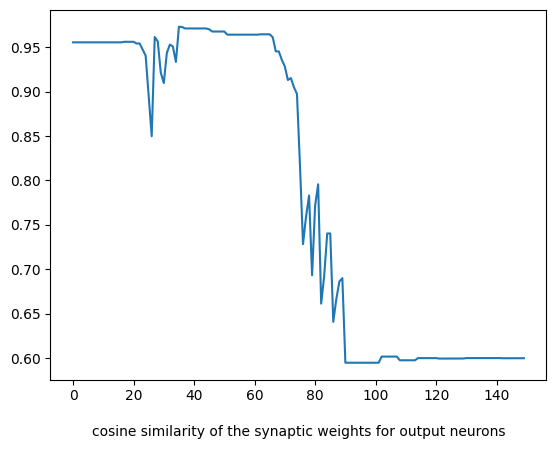

In [104]:
A1 = Syn1["W", 0][:,:,0]
A2 = Syn2["W", 0][:,:,0]

B1 = Syn1["W", 0][:,:,1]
B2 = Syn2["W", 0][:,:,1]

A = torch.cat((A1, A2), 1)
B = torch.cat((B1, B2), 1)

plt.plot(torch.nn.functional.cosine_similarity(A, B, dim = 1))
plt.xlabel("\ncosine similarity of the synaptic weights for output neurons")

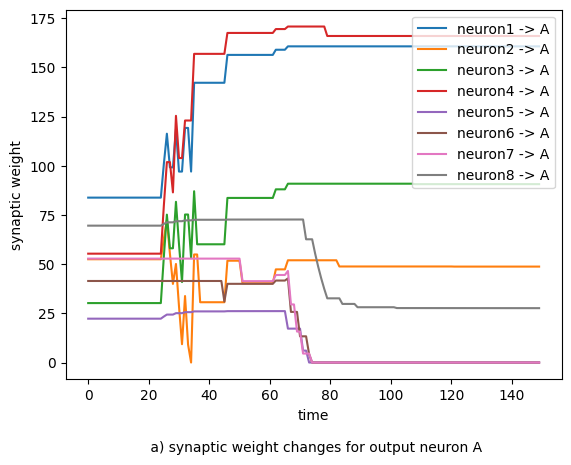

In [105]:
plt.plot(A)
plt.legend(["neuron{} -> A".format(i + 1) for i in range(8)], loc="upper right")
plt.ylabel("synaptic weight")
plt.xlabel("time\n\n a) synaptic weight changes for output neuron A")
plt.show()

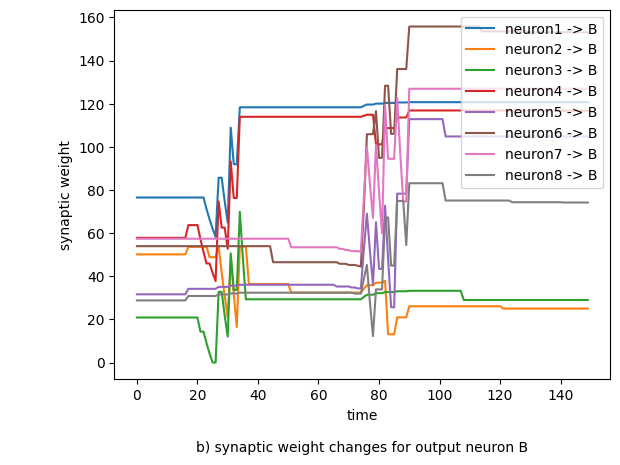

In [106]:
plt.plot(B)
plt.legend(["neuron{} -> B".format(i + 1) for i in range(8)], loc="upper right")
plt.ylabel("\n\n\nsynaptic weight")
plt.xlabel("time\n\nb) synaptic weight changes for output neuron B")
plt.show()

# with common neurons

Network['Network_1', 'Network'](Neurons: tensor(10)|4 groups, Synapses: tensor(16)|3 groups){1:TimeResolution()}
NeuronGroup['NG_IN1', 'NeuronGroup', 'ng'](3){2:PoissonGenerator(landa=[30],duration=[40],offset=[10],)6:Trace(tau=10,)9:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=ng_in_evrec,arg_0=['spike'],)}
NeuronGroup['NG_IN2', 'NeuronGroup', 'ng'](3){2:PoissonGenerator(landa=[20],duration=[40],offset=[50],)6:Trace(tau=10,)9:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=ng_in_evrec,arg_0=['spike'],)}
NeuronGroup['NG_IN3', 'NeuronGroup', 'ng'](2){2:PoissonGenerator(landa=[30, 20],duration=[40, 40],offset=[10, 50],)6:Trace(tau=10,)9:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=ng_in_evrec,arg_0=['spike'],)}
NeuronGroup['NG_OUT', 'NeuronGroup', 'ng'](2){4:InpSyn()5:LIF(tau=10,u_rest=-65,u_reset=-73,threshold=-10,R=1,v_init=normal(-40, 10),)6:Trace(tau=10,)7:STDP(A=10,)9:EventRecorder(

C:\Users\USER\AppData\Local\Temp\ipykernel_24412\1563923190.py:9: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  prob = ((landa**int(k))*np.exp(-landa))/np.math.factorial(int(k))


150xBatch: 1/1 (100%) 292.454ms


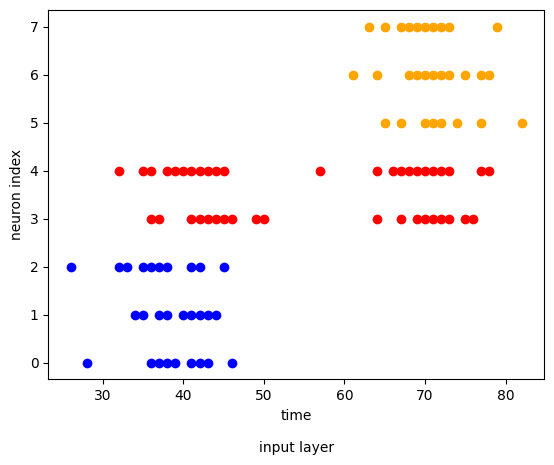

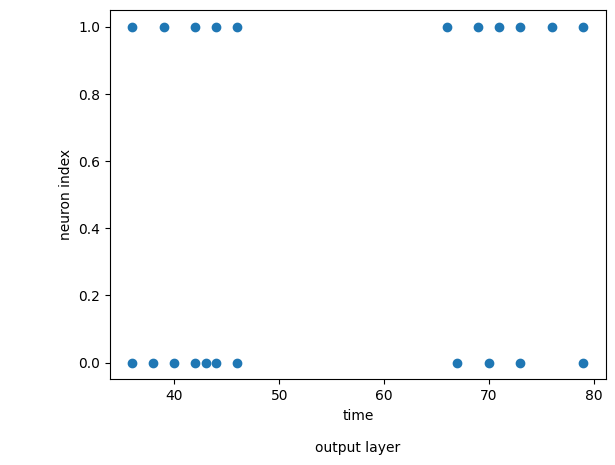

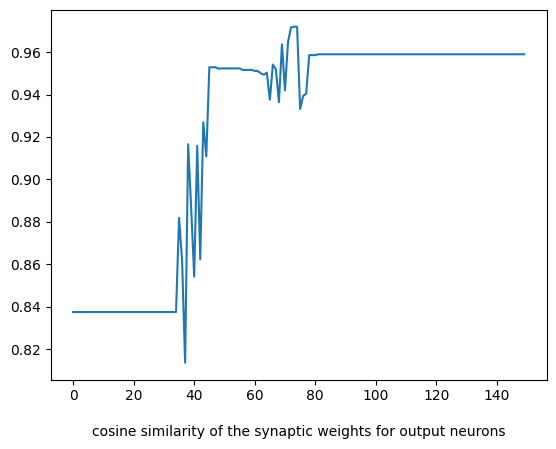

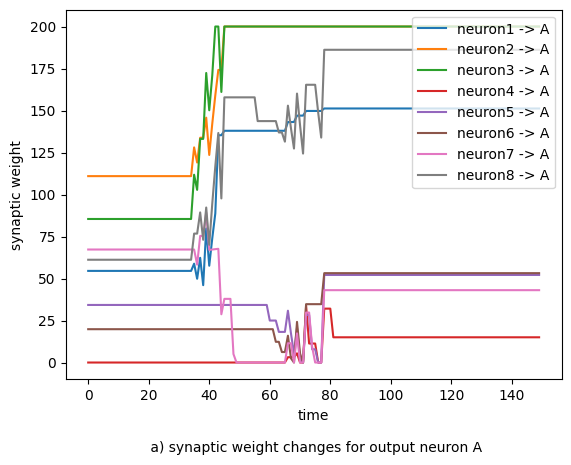

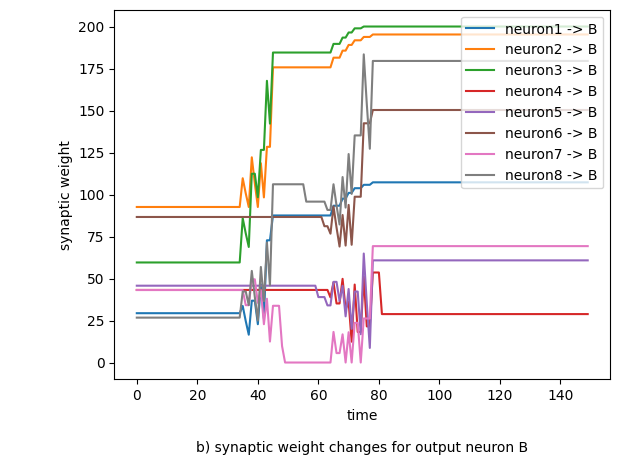

In [107]:
net1 = Network(behavior={1: TimeResolution()}, dtype=torch.float64)

ng_input1 = NeuronGroup(
    3,
    net = net1, 
    behavior={ 2 : PoissonGenerator(landa = [30], duration = [40], offset= [10]),
              
                6 : Trace(tau = 10),
                9 : EventRecorder(["spike"], tag="ng_in_evrec"),
                },
                tag="NG_IN1",
)
ng_input2 = NeuronGroup(
    3,
    net = net1, 
    behavior={ 2 : PoissonGenerator(landa = [20], duration = [40], offset = [50]),
              
                6 : Trace(tau = 10),
                9 : EventRecorder(["spike"], tag="ng_in_evrec"),
                },
                tag="NG_IN2",
)
ng_input3 = NeuronGroup(
    2,
    net = net1, 
    behavior={ 2 : PoissonGenerator(landa = [30, 20], duration = [40, 40], offset = [10, 50]),
              
                6 : Trace(tau = 10),
                9 : EventRecorder(["spike"], tag="ng_in_evrec"),
                },
                tag="NG_IN3",
)

ng_output = NeuronGroup(
    2,
    net = net1, 
    behavior={  4 : InpSyn(),
                5 : LIF(
                    tau=10,
                    u_rest=-65,
                    u_reset=-73,
                    threshold=-10,
                    R=1,
                    v_init="normal(-40, 10)",
                ),
                6 : Trace(tau = 10),
                7 : STDP(A=10),
                9 : EventRecorder(["spike"], tag="ng_out_evrec"),
                },
                tag="NG_OUT",

)

Syn1 = SynapseGroup(net=net1, src=ng_input1, dst=ng_output, behavior={
                2: Full(J_0=100),
                3: SynFun(),
                9: Recorder(["W"]),               
            })

Syn2 = SynapseGroup(net=net1, src=ng_input2, dst=ng_output, behavior={
                2: Full(J_0=100),
                3: SynFun(),
                9: Recorder(["W"]) ,
            })

Syn3 = SynapseGroup(net=net1, src=ng_input3, dst=ng_output, behavior={
                2: Full(J_0=100),
                3: SynFun(),
                9: Recorder(["W"]) ,
            })

net1.initialize()
net1.simulate_iterations(150)

plt.scatter(net1["spike", 0][:,0], net1["spike", 0][:,1], color = "blue")
plt.scatter(net1["spike", 2][:,0], net1["spike", 2][:,1]+3, color = "red")
plt.scatter(net1["spike", 1][:,0], net1["spike", 1][:,1]+5, color = "orange")
plt.xlabel("time\n\ninput layer")
plt.ylabel("neuron index")
plt.show()

plt.scatter(ng_output["spike", 0][:,0], ng_output["spike", 0][:,1])
plt.xlabel("time\n\noutput layer")
plt.ylabel("\n\n\nneuron index")
plt.show()

A1 = Syn1["W", 0][:,:,0]
A2 = Syn2["W", 0][:,:,0]
A3 = Syn3["W", 0][:,:,0]

B1 = Syn1["W", 0][:,:,1]
B2 = Syn2["W", 0][:,:,1]
B3 = Syn3["W", 0][:,:,1]

A = torch.cat((A1, A2, A3), 1)
B = torch.cat((B1, B2, B3), 1)

plt.plot(torch.nn.functional.cosine_similarity(A, B, dim = 1))
plt.xlabel("\ncosine similarity of the synaptic weights for output neurons")
plt.show()

plt.plot(A)
plt.legend(["neuron{} -> A".format(i + 1) for i in range(8)], loc="upper right")
plt.ylabel("synaptic weight")
plt.xlabel("time\n\n a) synaptic weight changes for output neuron A")
plt.show()

plt.plot(B)
plt.legend(["neuron{} -> B".format(i + 1) for i in range(8)], loc="upper right")
plt.ylabel("\n\n\nsynaptic weight")
plt.xlabel("time\n\nb) synaptic weight changes for output neuron B")
plt.show()

# Adding isolated neurons

Network['Network_1', 'Network'](Neurons: tensor(12)|5 groups, Synapses: tensor(27)|6 groups){1:TimeResolution()}
NeuronGroup['NG_IN1', 'NeuronGroup', 'ng'](4){2:PoissonGenerator(landa=[30],duration=[40],offset=[10],)5:BackAct(spike_prob=0.02,)6:Trace(tau=10,)9:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=ng_in_evrec,arg_0=['spike'],)}
NeuronGroup['NG_IN2', 'NeuronGroup', 'ng'](4){2:PoissonGenerator(landa=[30],duration=[40],offset=[40],)5:BackAct(spike_prob=0.02,)6:Trace(tau=10,)9:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=ng_in_evrec,arg_0=['spike'],)}
NeuronGroup['NG_IN3', 'NeuronGroup', 'ng'](1){2:PoissonGenerator(landa=[0],duration=[0],offset=[0],)5:BackAct(spike_prob=0.02,)6:Trace(tau=10,)9:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=ng_in_evrec,arg_0=['spike'],)}
NeuronGroup['NG_OUT', 'NeuronGroup', 'ng'](2){3:InpSyn()4:LIF(tau=10,u_rest=-65,u_reset=-73,threshold=-10,R=1,v_i

C:\Users\USER\AppData\Local\Temp\ipykernel_24412\1563923190.py:9: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  prob = ((landa**int(k))*np.exp(-landa))/np.math.factorial(int(k))


150xBatch: 1/1 (100%) 287.081ms


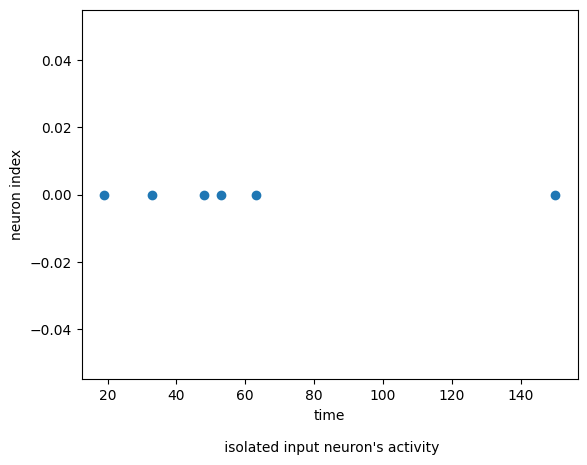

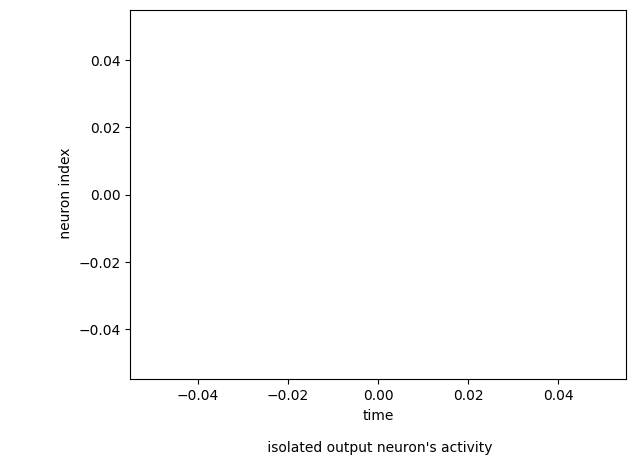

Text(0.5, 0, 'time\n\nsynaptic weight changes for output neurons')

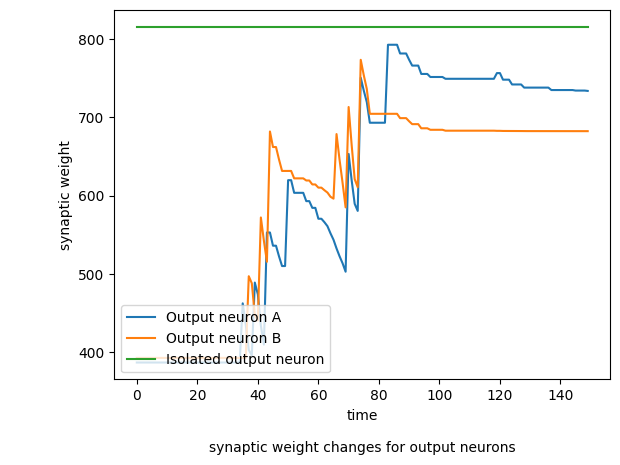

In [108]:
net1 = Network(behavior={1: TimeResolution()}, dtype=torch.float64)

ng_input1 = NeuronGroup(
    4,
    net = net1, 
    behavior={ 2 : PoissonGenerator(landa = [30], duration = [40], offset= [10]),
                
                5 : BackAct(spike_prob = 0.02),
                6 : Trace(tau = 10),
                9 : EventRecorder(["spike"], tag="ng_in_evrec"),
                },
                tag="NG_IN1",
)
ng_input2 = NeuronGroup(
    4,
    net = net1, 
    behavior={ 2 : PoissonGenerator(landa = [30], duration = [40], offset = [40]),
                
                5 : BackAct(spike_prob = 0.02),
                6 : Trace(tau = 10),
                9 : EventRecorder(["spike"], tag="ng_in_evrec"),
                },
                tag="NG_IN2",
)
ng_input_iso = NeuronGroup(
    1,
    net = net1, 
    behavior={ 2 : PoissonGenerator(landa = [0], duration = [0], offset = [0]),
                
                5 : BackAct(spike_prob = 0.02),
                6 : Trace(tau = 10),
                9 : EventRecorder(["spike"], tag="ng_in_evrec"),
                },
                tag="NG_IN3",
)

ng_output = NeuronGroup(
    2,
    net = net1, 
    behavior={  3 : InpSyn(),
                4 : LIF(
                    tau=10,
                    u_rest=-65,
                    u_reset=-73,
                    threshold=-10,
                    R=1,
                    v_init="normal(-40, 10)",
                ),
                5 : BackAct(spike_prob = 0.02),
                6 : Trace(tau = 10),
                7 : STDP(A=10),
                9 : EventRecorder(["spike"], tag="ng_out_evrec"),
                },
                tag="NG_OUT",

)
ng_output_iso = NeuronGroup(
    1,
    net = net1, 
    behavior={  3 : InpSyn(),
                4 : LIF(
                    tau=10,
                    u_rest=-65,
                    u_reset=-73,
                    threshold=10000,
                    R=1,
                    v_init="normal(-40, 10)",
                ),
                5 : BackAct(spike_prob = 0.02),
                6 : Trace(tau = 10),
                7 : STDP(A=10),
                9 : EventRecorder(["spike"], tag="ng_out_evrec"),
                },
                tag="NG_OUT",

)

Syn1 = SynapseGroup(net=net1, src=ng_input1, dst=ng_output, behavior={
                2: Full(J_0=100),
                3: SynFun(),
                9: Recorder(["W"]),               
            })

Syn2 = SynapseGroup(net=net1, src=ng_input2, dst=ng_output, behavior={
                2: Full(J_0=100),
                3: SynFun(),
                9: Recorder(["W"]) ,
            })

Syn3 = SynapseGroup(net=net1, src=ng_input_iso, dst=ng_output, behavior={
                2: Full(J_0=100),
                3: SynFun(),
                9: Recorder(["W"]) ,
            })

Syn4 = SynapseGroup(net=net1, src=ng_input1, dst=ng_output_iso, behavior={
                2: Full(J_0=100),
                3: SynFun(),
                9: Recorder(["W"]) ,
            })

Syn5 = SynapseGroup(net=net1, src=ng_input2, dst=ng_output_iso, behavior={
                2: Full(J_0=100),
                3: SynFun(),
                9: Recorder(["W"]) ,
            })
Syn6 = SynapseGroup(net=net1, src=ng_input_iso, dst=ng_output_iso, behavior={
                2: Full(J_0=100),
                3: SynFun(),
                9: Recorder(["W"]) ,
            })


net1.initialize()
net1.simulate_iterations(150)




plt.scatter(ng_input_iso["spike.t", 0], ng_input_iso["spike.i", 0])
plt.xlabel("time\n\n isolated input neuron's activity")
plt.ylabel("neuron index")
plt.show()

plt.scatter(ng_output_iso["spike.t", 0], ng_output_iso["spike.i", 0])
plt.xlabel("time\n\n isolated output neuron's activity")
plt.ylabel("\n\n\n neuron index")
plt.show()


plt.plot(torch.sum(Syn1['W', 0], axis = 1) + torch.sum(Syn2['W', 0], axis = 1) + torch.sum(Syn3['W', 0], axis = 1))
plt.plot(torch.sum(Syn4['W', 0], axis = 1) + torch.sum(Syn5['W', 0], axis = 1) + torch.sum(Syn6['W', 0], axis = 1))
plt.legend(["Output neuron A", "Output neuron B", "Isolated output neuron"], loc="lower left")
plt.ylabel("\n\n\nsynaptic weight")
plt.xlabel("time\n\nsynaptic weight changes for output neurons")


Text(0.5, 0, 'time\n\nsynaptic weight changes for output neurons')

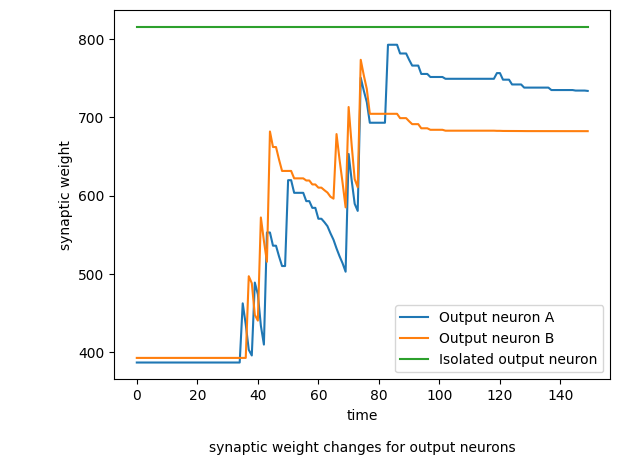

In [109]:
plt.plot(torch.sum(Syn1['W', 0], axis = 1) + torch.sum(Syn2['W', 0], axis = 1) + torch.sum(Syn3['W', 0], axis = 1))
plt.plot(torch.sum(Syn4['W', 0], axis = 1) + torch.sum(Syn5['W', 0], axis = 1) + torch.sum(Syn6['W', 0], axis = 1))
plt.legend(["Output neuron A", "Output neuron B", "Isolated output neuron"], loc="lower right")
plt.ylabel("\n\n\nsynaptic weight")
plt.xlabel("time\n\nsynaptic weight changes for output neurons")

# Adding background activity

In [110]:
class BackAct(Behavior) : 

    def initialize(self, ng) : 
        self.spike_prob = self.parameter("spike_prob", 0.2)

    def forward(self, ng) : 
        randnum = torch.rand(ng.size)
        ng.spike[randnum <= self.spike_prob] = 1

In [111]:
Syn1["W", 0][:,:,0].shape

torch.Size([150, 4])

In [112]:
A1 = Syn1.W[:,0]
A2 = Syn2.W[:,0]
B1 = Syn1.W[:,1]
B2 = Syn2.W[:,1]
# print(B2)
A = torch.cat((A1, A2), 0)
B = torch.cat((B1, B2), 0)

print("A : ", A)
print("B : ", B)

torch.nn.functional.cosine_similarity(A, B, dim = 0)

A :  tensor([172.9632,  61.3997, 102.3587,  74.6160,  93.3556,  86.9637,  58.1079,
         71.3116], dtype=torch.float64)
B :  tensor([117.7518, 141.0821, 151.6511,  34.1605,  35.5858,  37.7856,  15.1204,
         65.3746], dtype=torch.float64)


tensor(0.8507, dtype=torch.float64)

In [113]:
class PoissonGenerator(Behavior):
    def initialize(self, ng):
        ng.spike = ng.vector("zeros")
        self.offset = self.parameter("offset")
        self.duration = self.parameter("duration")
        self.landa = self.parameter("landa")

    def p_dist(self, landa, k):
        prob = ((landa**int(k))*np.exp(-landa))/np.math.factorial(int(k))
        return prob

    def find_pattern(self, ng):
        for i in range(0, len(self.offset)):
            if ng.network.iteration >= self.offset[i] and ng.network.iteration <= self.offset[i] + self.duration[i] :
                return i
        return -1
         

    def forward(self, ng):
        # ng.spike = ng.vector("zeros")
        index = self.find_pattern(ng)
        for i in range(0, ng.size):
            if index == -1:
                ng.spike = ng.vector("zeros")
                break
            else:
                ng.spike[i] = self.p_dist(self.landa[index], ng.network.iteration-self.offset[index])*8 >= torch.rand(1)


# R-STDP

In [114]:
class RSTDP(Behavior):
    def initialize(self, ng):
        self.d = self.parameter("d", 0) 
        self.tau_d = self.parameter("tau_d", 10)
        self.tau_c = self.parameter("tau_c", 50)
        self.A = self.parameter("A", 10)
        self.target = self.parameter("target") # = neuron index 0 or 1

        self.test_time = self.parameter("test_time")

    def STDP(self, syn):
        delta_w = (-self.A * syn.dst.post_trace * syn.src.spike[: , None] + self.A * syn.src.pre_trace[: , None] * syn.dst.spike)*syn.network.dt
        return delta_w
        
        
    def DA(self, ng):
        spike_sum = torch.sum(ng.spike, dim =0)
        if spike_sum == 1 and ng.spike[self.target] == 1:
            return 1
        elif spike_sum > 0 :
            return -4
        print(ng.network.iteration, self.d)
        return 0

    def Delta_d(self, ng):
        delta_d = (-self.d/self.tau_d + self.DA(ng)) * ng.network.dt
        self.d += delta_d

    def forward(self, ng):
        if(ng.network.iteration >= self.test_time) : 
            return

        self.Delta_d(ng)
        # print(self.d)
        for syn in ng.afferent_synapses["All"]:
            delta_c = (-(syn.c/self.tau_c) + self.STDP(syn)) * ng.network.dt
            syn.c += delta_c
            
            delta_w = self.d * syn.c * ng.network.dt
            syn.W = torch.clip(syn.W + delta_w, 0.0, 200.0)

Network['Network_1', 'Network'](Neurons: tensor(10)|3 groups, Synapses: tensor(16)|2 groups){1:TimeResolution()}
NeuronGroup['NG_IN1', 'NeuronGroup', 'ng'](4){2:PoissonGenerator(landa=[20, 20, 20, 20, 20, 20],duration=[30, 30, 30, 30, 30, 30],offset=[0, 60, 120, 180, 240, 340],)6:Trace(tau=30,)9:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=ng_in_evrec,arg_0=['spike'],)}
NeuronGroup['NG_IN2', 'NeuronGroup', 'ng'](4){2:PoissonGenerator(landa=[20, 20, 20, 20, 20, 20],duration=[30, 30, 30, 30, 30, 30],offset=[0, 60, 120, 180, 240, 340],)6:Trace(tau=30,)9:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=ng_in_evrec,arg_0=['spike'],)}
NeuronGroup['NG_OUT', 'NeuronGroup', 'ng'](2){4:InpSyn()5:LIF(tau=10,u_rest=-65,u_reset=-73,threshold=-13,R=8,v_init=normal(-40, 10),)6:Trace(tau=30,)7:RSTDP(A=0.2,tau_c=40,tau_d=20,target=0,test_time=300,)9:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=ng_out_ev

C:\Users\USER\AppData\Local\Temp\ipykernel_24412\4060324533.py:9: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  prob = ((landa**int(k))*np.exp(-landa))/np.math.factorial(int(k))


151 12.337963652475224
152 11.721065469851464
153 11.13501219635889
154 10.578261586540945
155 10.049348507213898
156 9.546881081853202
157 9.069537027760543
158 8.616060176372516
159 8.18525716755389
160 7.7759943091761965
161 7.387194593717386
162 7.017834864031517
163 6.6669431208299414
164 6.3335959647884446
165 6.016916166549023
166 5.716070358221572
167 5.430266840310493
168 5.158753498294968
169 4.90081582338022
170 4.655775032211209
171 4.422986280600648
172 4.201836966570616
173 3.991745118242085
174 3.7921578623299808
175 3.6025499692134817
176 3.4224224707528075
177 3.251301347215167
178 3.088736279854409
179 2.9342994658616885
180 2.787584492568604
181 2.648205267940174
182 2.515795004543165
183 2.390005254316007
184 2.2705049916002067
185 2.156979742020196
186 2.049130754919186
187 1.9466742171732268
188 1.8493405063145654
189 1.7568734809988371
190 1.6690298069488954
191 1.5855783166014505
192 1.506299400771378
213 13.343269325432667
214 12.676105859161034
216 12.44018553

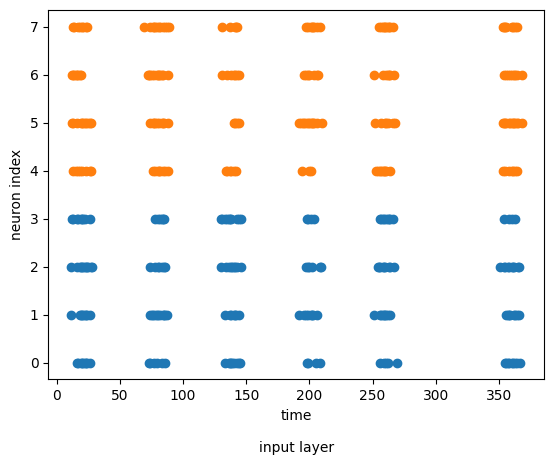

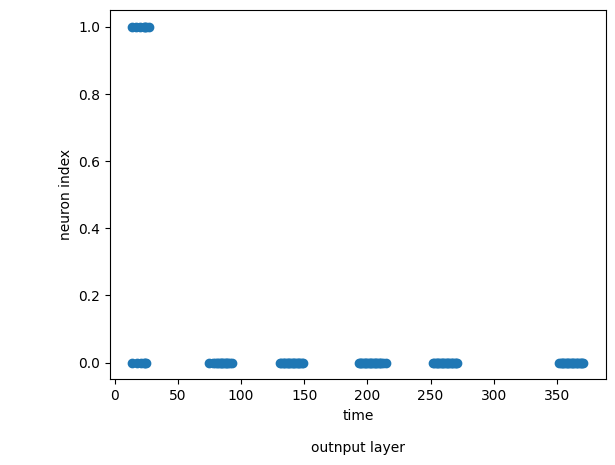

In [115]:
net1 = Network(behavior={1: TimeResolution()}, dtype=torch.float64)

ng_input1 = NeuronGroup(
    4,
    net = net1, 
    behavior={ 2 : PoissonGenerator(landa = [20, 20, 20, 20, 20, 20], duration = [30, 30, 30, 30, 30, 30], offset= [0, 60, 120, 180, 240, 340]),
              
                6 : Trace(tau = 30),
                9 : EventRecorder(["spike"], tag="ng_in_evrec"),
                },
                tag="NG_IN1",
)
ng_input2 = NeuronGroup(
    4,
    net = net1, 
    behavior={ 2 : PoissonGenerator(landa = [20, 20, 20, 20, 20, 20], duration = [30, 30, 30, 30, 30, 30], offset= [0, 60, 120, 180, 240, 340]),
              
                6 : Trace(tau = 30),
                9 : EventRecorder(["spike"], tag="ng_in_evrec"),
                },
                tag="NG_IN2",
)

ng_output = NeuronGroup(
    2,
    net = net1, 
    behavior={  4 : InpSyn(),
                5 : LIF(
                    tau=10,
                    u_rest=-65,
                    u_reset=-73,
                    threshold=-13,
                    R=8,
                    v_init="normal(-40, 10)",
                ),
                6 : Trace(tau = 30),
                7 : RSTDP(A=0.2, tau_c = 40, tau_d = 20, target = 0, test_time = 300),
                9 : EventRecorder(["spike"], tag="ng_out_evrec"),
                },
                tag="NG_OUT",

)

Syn1 = SynapseGroup(net=net1, src=ng_input1, dst=ng_output, behavior={
                2: Full(J_0=10),
                3: SynFun(),
                9: Recorder(["W"]),               
            })

Syn2 = SynapseGroup(net=net1, src=ng_input2, dst=ng_output, behavior={
                2: Full(J_0=10),
                3: SynFun(),
                9: Recorder(["W"]) ,
            })

net1.initialize()
net1.simulate_iterations(400)

plt.scatter(ng_input1["spike", 0][:,0], ng_input1["spike", 0][:,1])
plt.scatter(ng_input2["spike", 0][:,0], ng_input2["spike", 0][:,1] + 4)
plt.xlabel("time\n\ninput layer")
plt.ylabel("neuron index")
plt.show()

plt.scatter(ng_output["spike", 0][:,0], ng_output["spike", 0][:,1])
plt.xlabel("time\n\noutnput layer")
plt.ylabel("\n\n\nneuron index")
plt.show()


Text(0.5, 0, '\ncosine similarity of the synaptic weights for output neurons')

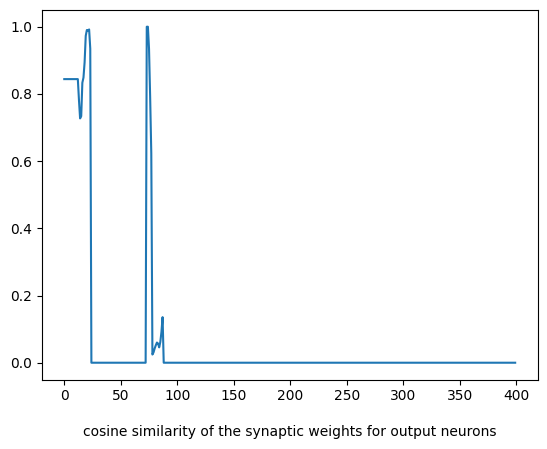

In [116]:
A1 = Syn1["W", 0][:,:,0]
A2 = Syn2["W", 0][:,:,0]

B1 = Syn1["W", 0][:,:,1]
B2 = Syn2["W", 0][:,:,1]

A = torch.cat((A1, A2), 1)
B = torch.cat((B1, B2), 1)

plt.plot(torch.nn.functional.cosine_similarity(A, B, dim = 1))
plt.xlabel("\ncosine similarity of the synaptic weights for output neurons")

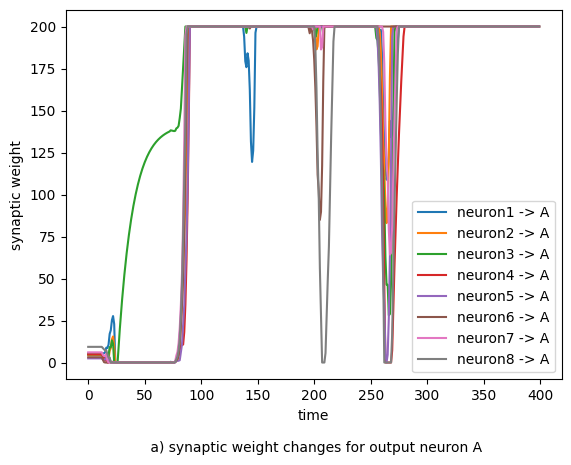

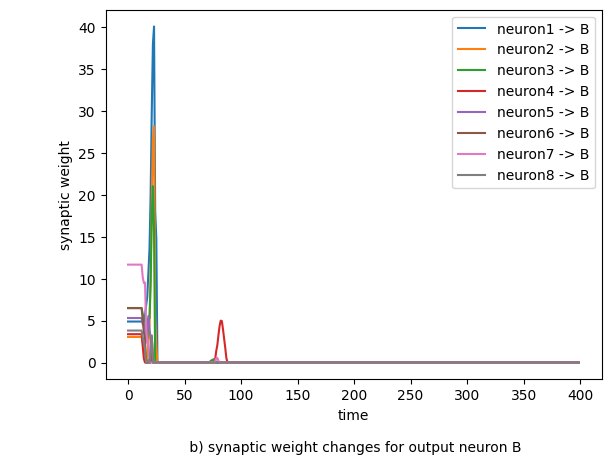

In [117]:
plt.plot(A)
plt.legend(["neuron{} -> A".format(i + 1) for i in range(8)])
plt.ylabel("synaptic weight")
plt.xlabel("time\n\n a) synaptic weight changes for output neuron A")
plt.show()

plt.plot(B)
plt.legend(["neuron{} -> B".format(i + 1) for i in range(8)])
plt.ylabel("\n\n\nsynaptic weight")
plt.xlabel("time\n\n b) synaptic weight changes for output neuron B")
plt.show()

# R-STDP with background activity

Network['Network_1', 'Network'](Neurons: tensor(10)|3 groups, Synapses: tensor(16)|2 groups){1:TimeResolution()}
NeuronGroup['NG_IN1', 'NeuronGroup', 'ng'](4){2:PoissonGenerator(landa=[20, 20],duration=[30, 30],offset=[0, 100],)5:BackAct(spike_prob=0.02,)6:Trace(tau=30,)9:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=ng_in_evrec,arg_0=['spike'],)}
NeuronGroup['NG_IN2', 'NeuronGroup', 'ng'](4){2:PoissonGenerator(landa=[20, 20],duration=[30, 30],offset=[50, 150],)5:BackAct(spike_prob=0.02,)6:Trace(tau=30,)9:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=ng_in_evrec,arg_0=['spike'],)}
NeuronGroup['NG_OUT', 'NeuronGroup', 'ng'](2){3:InpSyn()4:LIF(tau=10,u_rest=-65,u_reset=-73,threshold=-10,R=1,v_init=normal(-40, 10),)5:BackAct(spike_prob=0.02,)6:Trace(tau=30,)7:RSTDP(A=0.2,tau_c=40,tau_d=20,target=0,test_time=300,)9:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=ng_out_evrec,arg_0=['spike'],

C:\Users\USER\AppData\Local\Temp\ipykernel_24412\4060324533.py:9: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  prob = ((landa**int(k))*np.exp(-landa))/np.math.factorial(int(k))


181 -13.69427148920009
182 -13.009557914740085
183 -12.35908001900308
184 -11.741126018052926
185 -11.15406971715028
186 -10.596366231292766
187 -10.066547919728128
188 -9.563220523741721
190 -12.630806522676902
192 -10.399302886715905
193 -9.879337742380109
194 -9.385370855261103
195 -8.916102312498047
196 -8.470297196873146
197 -8.046782337029489
198 -7.644443220178014
199 -7.262221059169113
200 -6.899110006210658
200xBatch: 1/1 (100%) 217.133ms


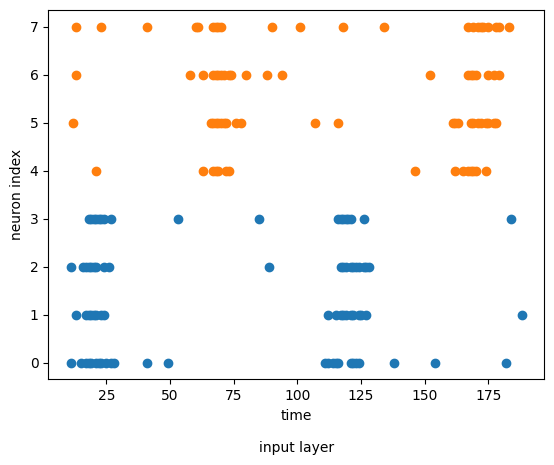

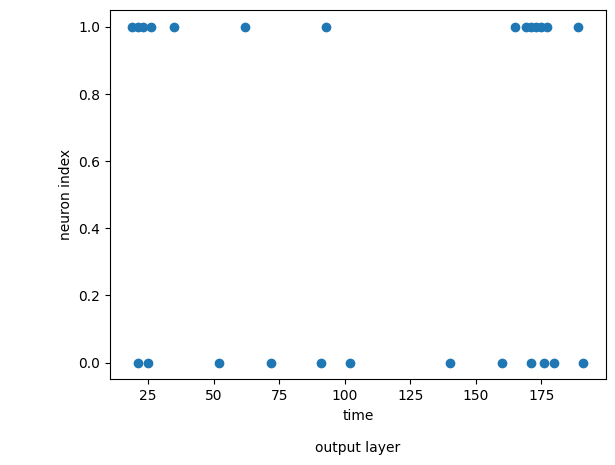

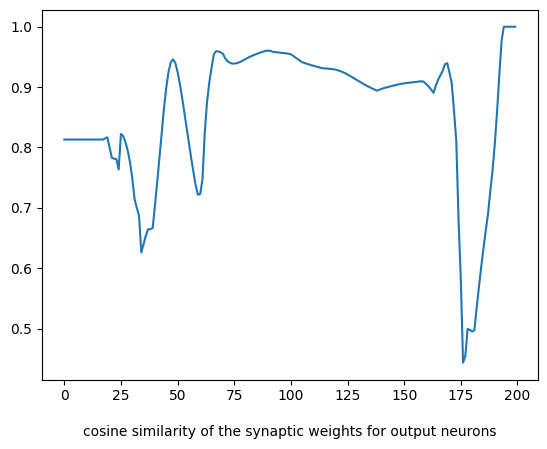

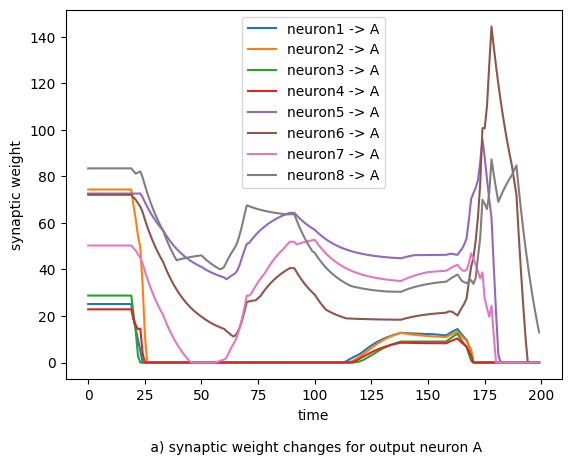

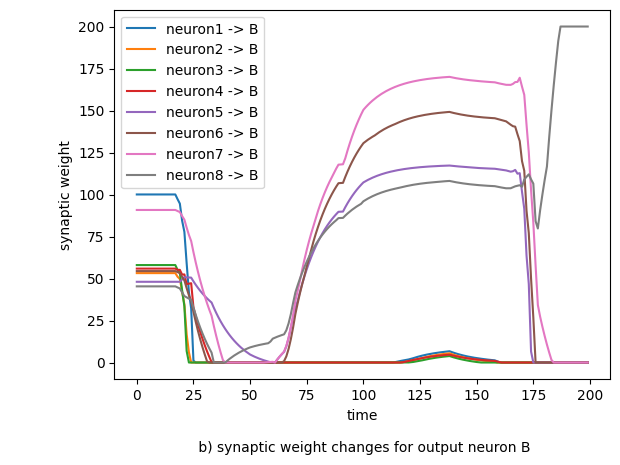

In [118]:
net1 = Network(behavior={1: TimeResolution()}, dtype=torch.float64)

ng_input1 = NeuronGroup(
    4,
    net = net1, 
    behavior={ 2 :PoissonGenerator(landa = [20, 20], duration = [30, 30], offset= [0, 100]),
              
                5 : BackAct(spike_prob = 0.02),
                6 : Trace(tau = 30),
                9 : EventRecorder(["spike"], tag="ng_in_evrec"),
                },
                tag="NG_IN1",
)
ng_input2 = NeuronGroup(
    4,
    net = net1, 
    behavior={ 2 : PoissonGenerator(landa = [20, 20], duration = [30, 30], offset= [50, 150]),
              
                5 : BackAct(spike_prob = 0.02),
                6 : Trace(tau = 30),
                9 : EventRecorder(["spike"], tag="ng_in_evrec"),
                },
                tag="NG_IN2",
)

ng_output = NeuronGroup(
    2,
    net = net1, 
    behavior={  3 : InpSyn(),
                4 : LIF(
                    tau=10,
                    u_rest=-65,
                    u_reset=-73,
                    threshold=-10,
                    R=1,
                    v_init="normal(-40, 10)",
                ),
                5 : BackAct(spike_prob = 0.02),
                6 : Trace(tau = 30),
                7 : RSTDP(A=0.2, tau_c = 40, tau_d = 20, target = 0, test_time = 300),
                9 : EventRecorder(["spike"], tag="ng_out_evrec"),
                },
                tag="NG_OUT",

)

Syn1 = SynapseGroup(net=net1, src=ng_input1, dst=ng_output, behavior={
                2: Full(J_0=100),
                3: SynFun(),
                9: Recorder(["W"]),               
            })

Syn2 = SynapseGroup(net=net1, src=ng_input2, dst=ng_output, behavior={
                2: Full(J_0=100),
                3: SynFun(),
                9: Recorder(["W"]) ,
            })

net1.initialize()
net1.simulate_iterations(200)

plt.scatter(ng_input1["spike", 0][:,0], ng_input1["spike", 0][:,1])
plt.scatter(ng_input2["spike", 0][:,0], ng_input2["spike", 0][:,1] + 4)
plt.xlabel("time\n\ninput layer")
plt.ylabel("neuron index")
plt.show()

plt.scatter(ng_output["spike", 0][:,0], ng_output["spike", 0][:,1])
plt.xlabel("time\n\noutput layer")
plt.ylabel("\n\n\nneuron index")
plt.show()

A1 = Syn1["W", 0][:,:,0]
A2 = Syn2["W", 0][:,:,0]

B1 = Syn1["W", 0][:,:,1]
B2 = Syn2["W", 0][:,:,1]

A = torch.cat((A1, A2), 1)
B = torch.cat((B1, B2), 1)

plt.plot(torch.nn.functional.cosine_similarity(A, B, dim = 1))
plt.xlabel("\ncosine similarity of the synaptic weights for output neurons")
plt.show()

plt.plot(A)
plt.legend(["neuron{} -> A".format(i + 1) for i in range(8)])
plt.ylabel("synaptic weight")
plt.xlabel("time\n\n a) synaptic weight changes for output neuron A")
plt.show()

plt.plot(B)
plt.legend(["neuron{} -> B".format(i + 1) for i in range(8)])
plt.ylabel("\n\n\nsynaptic weight")
plt.xlabel("time\n\n b) synaptic weight changes for output neuron B")
plt.show()


# R-STDP with isolated neurons

Network['Network_1', 'Network'](Neurons: tensor(12)|5 groups, Synapses: tensor(27)|6 groups){1:TimeResolution()}
NeuronGroup['NG_IN1', 'NeuronGroup', 'ng'](4){2:PoissonGenerator(landa=[20, 20],duration=[30, 30],offset=[0, 100],)5:BackAct(spike_prob=0.02,)6:Trace(tau=30,)9:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=ng_in_evrec,arg_0=['spike'],)}
NeuronGroup['NG_IN2', 'NeuronGroup', 'ng'](4){2:PoissonGenerator(landa=[20, 20],duration=[30, 30],offset=[50, 150],)5:BackAct(spike_prob=0.02,)6:Trace(tau=30,)9:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=ng_in_evrec,arg_0=['spike'],)}
NeuronGroup['NG_IN3', 'NeuronGroup', 'ng'](1){2:PoissonGenerator(landa=[0],duration=[0],offset=[0],)5:BackAct(spike_prob=0.02,)6:Trace(tau=30,)9:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=ng_in_evrec,arg_0=['spike'],)}
NeuronGroup['NG_OUT', 'NeuronGroup', 'ng'](2){3:InpSyn()4:LIF(tau=10,u_rest=-65,u_reset=

C:\Users\USER\AppData\Local\Temp\ipykernel_24412\4060324533.py:9: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  prob = ((landa**int(k))*np.exp(-landa))/np.math.factorial(int(k))


94 -0.1801327773417689
94 0.0700153280196324
95 -0.17112613847468047
95 0.06651456161865077
96 -0.16256983155094645
96 0.06318883353771823
97 -0.15444133997339912
97 0.06002939186083232
98 -0.14671927297472917
98 0.0570279222677907
99 -0.13938330932599272
99 0.05417652615440117
100 -0.13241414385969308
100 0.05146769984668111
101 -0.12579343666670842
101 0.04889431485434706
102 -0.119503764833373
102 0.04644959911162971
103 -0.11352857659170434
103 0.04412711915604822
104 -0.10785214776211913
104 0.04192076319824581
105 -0.10245954037401317
105 0.039824725038333515
106 -0.09733656335531252
106 0.03783348878641684
107 -0.09246973518754689
107 0.035941814347096
108 -0.08784624842816954
108 0.0341447236297412
109 0.032437487448254136
110 -4.0792812392064235
110 0.03081561307584143
111 -3.875317177246102
111 0.029274832422049358
112 -3.681551318383797
112 0.02781109080094689
113 -3.497473752464607
113 0.026420536260899543
114 -3.3226000648413767
114 0.025099509447854565
115 -3.156470061599

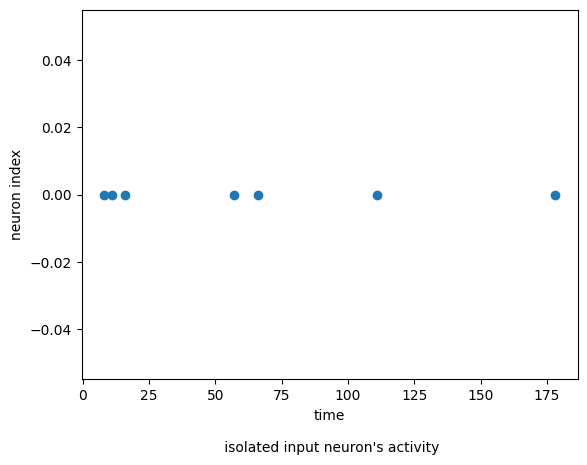

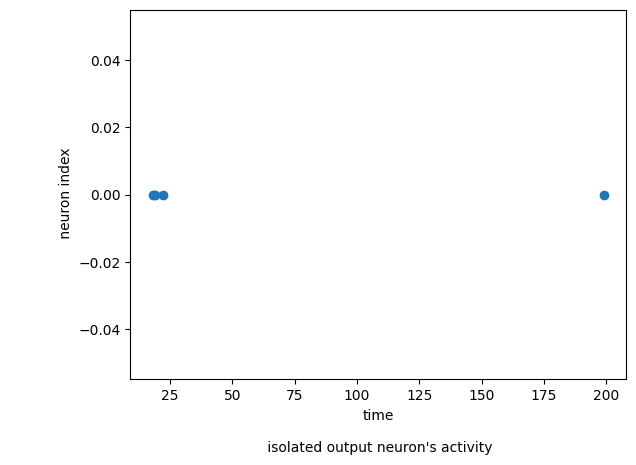

Text(0.5, 0, 'time\n\nsynaptic weight changes for output neurons')

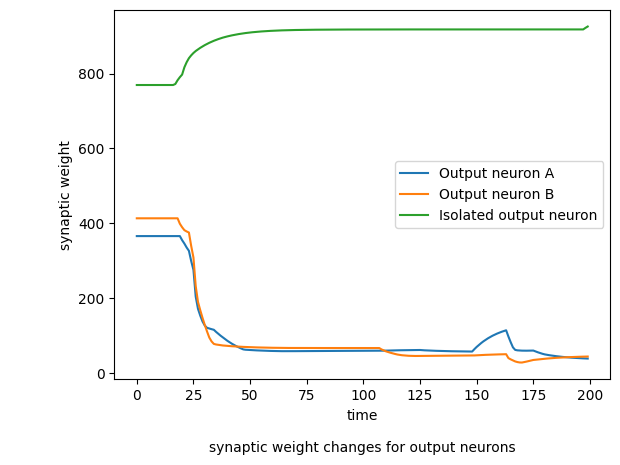

In [119]:
net1 = Network(behavior={1: TimeResolution()}, dtype=torch.float64)

ng_input1 = NeuronGroup(
    4,
    net = net1, 
    behavior={ 2 :PoissonGenerator(landa = [20, 20], duration = [30, 30], offset= [0, 100]),
              
                5 : BackAct(spike_prob = 0.02),
                6 : Trace(tau = 30),
                9 : EventRecorder(["spike"], tag="ng_in_evrec"),
                },
                tag="NG_IN1",
)
ng_input2 = NeuronGroup(
    4,
    net = net1, 
    behavior={ 2 : PoissonGenerator(landa = [20, 20], duration = [30, 30], offset= [50, 150]),
              
                5 : BackAct(spike_prob = 0.02),
                6 : Trace(tau = 30),
                9 : EventRecorder(["spike"], tag="ng_in_evrec"),
                },
                tag="NG_IN2",
)
ng_input_iso = NeuronGroup(
    1,
    net = net1, 
    behavior={ 2 : PoissonGenerator(landa = [0], duration = [0], offset = [0]),
                
                5 : BackAct(spike_prob = 0.02),
                6 : Trace(tau = 30),
                9 : EventRecorder(["spike"], tag="ng_in_evrec"),
                },
                tag="NG_IN3",
)

ng_output = NeuronGroup(
    2,
    net = net1, 
    behavior={  3 : InpSyn(),
                4 : LIF(
                    tau=10,
                    u_rest=-65,
                    u_reset=-73,
                    threshold=-10,
                    R=1,
                    v_init="normal(-40, 10)",
                ),
                5 : BackAct(spike_prob = 0.02),
                6 : Trace(tau = 10),
                7 : RSTDP(A=0.2, tau_c = 40, tau_d = 20, target = 0, test_time = 300),
                9 : EventRecorder(["spike"], tag="ng_out_evrec"),
                },
                tag="NG_OUT",

)
ng_output_iso = NeuronGroup(
    1,
    net = net1, 
    behavior={  3 : InpSyn(),
                4 : LIF(
                    tau=10,
                    u_rest=-65,
                    u_reset=-73,
                    threshold=10000,
                    R=1,
                    v_init="normal(-40, 10)",
                ),
                5 : BackAct(spike_prob = 0.02),
                6 : Trace(tau = 10),
                7 : RSTDP(A=0.2, tau_c = 40, tau_d = 20, target = 0, test_time = 300),
                9 : EventRecorder(["spike"], tag="ng_out_evrec"),
                },
                tag="NG_OUT",

)

Syn1 = SynapseGroup(net=net1, src=ng_input1, dst=ng_output, behavior={
                2: Full(J_0=100),
                3: SynFun(),
                9: Recorder(["W"]),               
            })

Syn2 = SynapseGroup(net=net1, src=ng_input2, dst=ng_output, behavior={
                2: Full(J_0=100),
                3: SynFun(),
                9: Recorder(["W"]) ,
            })

Syn3 = SynapseGroup(net=net1, src=ng_input_iso, dst=ng_output, behavior={
                2: Full(J_0=100),
                3: SynFun(),
                9: Recorder(["W"]) ,
            })

Syn4 = SynapseGroup(net=net1, src=ng_input1, dst=ng_output_iso, behavior={
                2: Full(J_0=100),
                3: SynFun(),
                9: Recorder(["W"]) ,
            })

Syn5 = SynapseGroup(net=net1, src=ng_input2, dst=ng_output_iso, behavior={
                2: Full(J_0=100),
                3: SynFun(),
                9: Recorder(["W"]) ,
            })
Syn6 = SynapseGroup(net=net1, src=ng_input_iso, dst=ng_output_iso, behavior={
                2: Full(J_0=100),
                3: SynFun(),
                9: Recorder(["W"]) ,
            })


net1.initialize()
net1.simulate_iterations(200)




plt.scatter(ng_input_iso["spike.t", 0], ng_input_iso["spike.i", 0])
plt.xlabel("time\n\n isolated input neuron's activity")
plt.ylabel("neuron index")
plt.show()

plt.scatter(ng_output_iso["spike.t", 0], ng_output_iso["spike.i", 0])
plt.xlabel("time\n\n isolated output neuron's activity")
plt.ylabel("\n\n\n neuron index")
plt.show()


plt.plot(torch.sum(Syn1['W', 0], axis = 1) + torch.sum(Syn2['W', 0], axis = 1) + torch.sum(Syn3['W', 0], axis = 1))
plt.plot(torch.sum(Syn4['W', 0], axis = 1) + torch.sum(Syn5['W', 0], axis = 1) + torch.sum(Syn6['W', 0], axis = 1))
plt.legend(["Output neuron A", "Output neuron B", "Isolated output neuron"], loc="center right")
plt.ylabel("\n\n\nsynaptic weight")
plt.xlabel("time\n\nsynaptic weight changes for output neurons")


Text(0.5, 0, 'time\n\nsynaptic weight changes for output neurons')

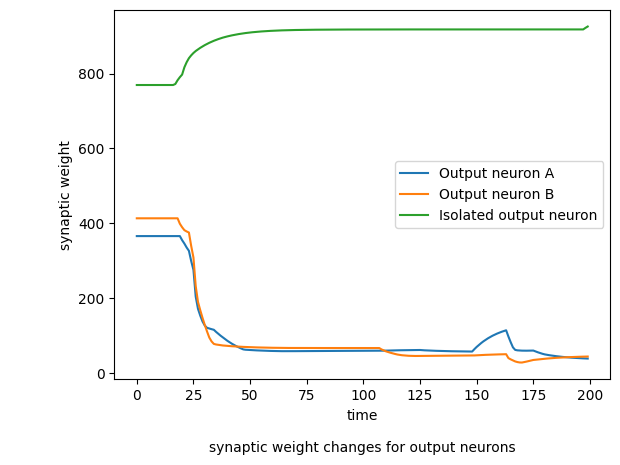

In [120]:
plt.plot(torch.sum(Syn1['W', 0], axis = 1) + torch.sum(Syn2['W', 0], axis = 1) + torch.sum(Syn3['W', 0], axis = 1))
plt.plot(torch.sum(Syn4['W', 0], axis = 1) + torch.sum(Syn5['W', 0], axis = 1) + torch.sum(Syn6['W', 0], axis = 1))
plt.legend(["Output neuron A", "Output neuron B", "Isolated output neuron"], loc="center right")
plt.ylabel("\n\n\nsynaptic weight")
plt.xlabel("time\n\nsynaptic weight changes for output neurons")

# R-STDP with common neurons

Network['Network_1', 'Network'](Neurons: tensor(10)|4 groups, Synapses: tensor(16)|3 groups){1:TimeResolution()}
NeuronGroup['NG_IN1', 'NeuronGroup', 'ng'](2){2:PoissonGenerator(landa=[20, 20, 20],duration=[20, 30, 25],offset=[0, 60, 90],)6:Trace(tau=30,)9:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=ng_in_evrec,arg_0=['spike'],)}
NeuronGroup['NG_IN2', 'NeuronGroup', 'ng'](2){2:PoissonGenerator(landa=[20, 20, 20],duration=[20, 30, 20],offset=[140, 200, 260],)6:Trace(tau=30,)9:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=ng_in_evrec,arg_0=['spike'],)}
NeuronGroup['NG_IN3', 'NeuronGroup', 'ng'](4){2:PoissonGenerator(landa=[20, 20, 20, 20, 20, 20],duration=[20, 30, 25, 20, 30, 20],offset=[0, 60, 90, 140, 200, 260],)6:Trace(tau=30,)9:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=ng_in_evrec,arg_0=['spike'],)}
NeuronGroup['NG_OUT', 'NeuronGroup', 'ng'](2){4:InpSyn()5:LIF(tau=10,u_rest=-65

C:\Users\USER\AppData\Local\Temp\ipykernel_24412\4060324533.py:9: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  prob = ((landa**int(k))*np.exp(-landa))/np.math.factorial(int(k))


163 -3.6113758059916417
164 -3.4308070156920594
165 -3.2592666649074564
166 -3.0963033316620834
167 -2.941488165078979
168 -2.7944137568250302
169 -2.6546930689837787
170 -2.5219584155345895
171 -2.39586049475786
172 -2.276067470019967
173 -2.1622640965189683
174 -2.05415089169302
175 -1.9514433471083688
176 -1.8538711797529503
177 -1.761177620765303
178 -1.6731187397270377
179 -1.5894628027406859
180 -1.5099896626036515
181 -1.434490179473469
182 -1.3627656704997955
183 -1.2946273869748057
184 -1.2298960176260654
185 -1.1684012167447622
186 -1.109981155907524
187 -1.0544820981121479
188 -1.0017579932065406
189 -0.9516700935462136
190 -0.9040865888689029
191 -0.8588822594254578
192 -0.8159381464541849
193 -0.7751412391314757
194 -0.7363841771749019
195 -0.6995649683161568
196 -0.6645867199003489
197 -0.6313573839053315
198 -0.5997895147100649
199 -0.5698000389745617
200 -0.5413100370258336
201 -0.5142445351745419
202 -0.48853230841581485
203 -0.46410569299502413
204 -0.4409004083452729

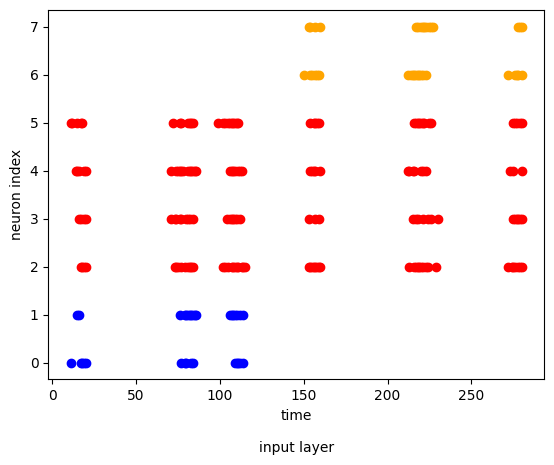

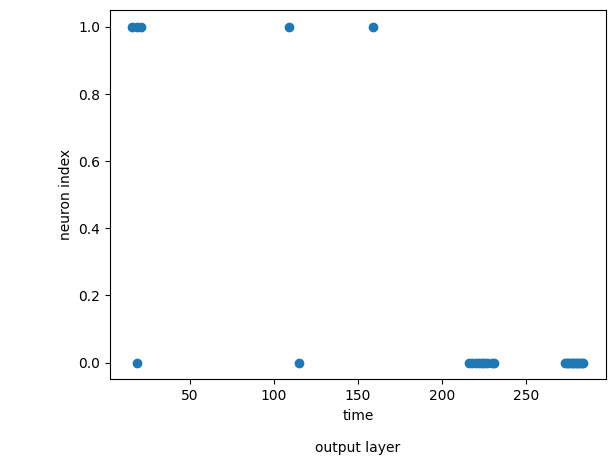

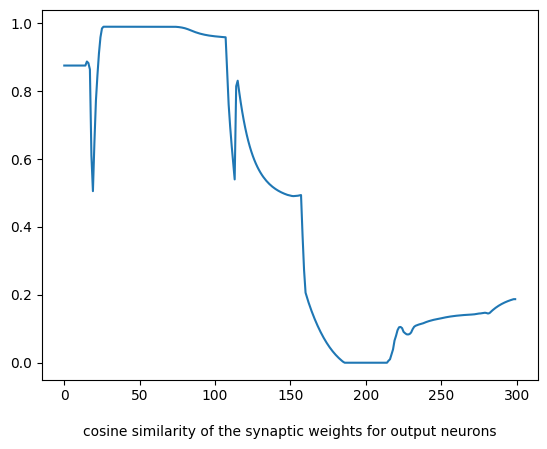

In [121]:
net1 = Network(behavior={1: TimeResolution()}, dtype=torch.float64)

ng_input1 = NeuronGroup(
    2,
    net = net1, 
    behavior={ 2 : PoissonGenerator(landa = [20, 20, 20], duration = [20, 30, 25], offset= [0, 60, 90]),
              
                6 : Trace(tau = 30),
                9 : EventRecorder(["spike"], tag="ng_in_evrec"),
                },
                tag="NG_IN1",
)
ng_input2 = NeuronGroup(
    2,
    net = net1, 
    behavior={ 2 : PoissonGenerator(landa = [20, 20, 20], duration = [20, 30, 20], offset= [140, 200, 260]),
              
                6 : Trace(tau = 30),
                9 : EventRecorder(["spike"], tag="ng_in_evrec"),
                },
                tag="NG_IN2",
)
ng_input3 = NeuronGroup(
    4,
    net = net1, 
    behavior={ 2 : PoissonGenerator(landa = [20, 20, 20, 20, 20, 20], duration = [20, 30, 25, 20, 30, 20], offset= [0, 60, 90, 140, 200, 260]),
              
                6 : Trace(tau = 30),
                9 : EventRecorder(["spike"], tag="ng_in_evrec"),
                },
                tag="NG_IN3",
)

ng_output = NeuronGroup(
    2,
    net = net1, 
    behavior={  4 : InpSyn(),
                5 : LIF(
                    tau=10,
                    u_rest=-65,
                    u_reset=-73,
                    threshold=-13,
                    R=8,
                    v_init="normal(-40, 10)",
                ),
                6 : Trace(tau = 30),
                7 : RSTDP(A=0.2, tau_c = 40, tau_d = 20, target = 0, test_time = 300),
                9 : EventRecorder(["spike"], tag="ng_out_evrec"),
                },
                tag="NG_OUT",

)

Syn1 = SynapseGroup(net=net1, src=ng_input1, dst=ng_output, behavior={
                2: Full(J_0=10),
                3: SynFun(),
                9: Recorder(["W"]),               
            })

Syn2 = SynapseGroup(net=net1, src=ng_input2, dst=ng_output, behavior={
                2: Full(J_0=10),
                3: SynFun(),
                9: Recorder(["W"]) ,
            })

Syn3 = SynapseGroup(net=net1, src=ng_input3, dst=ng_output, behavior={
                2: Full(J_0=10),
                3: SynFun(),
                9: Recorder(["W"]) ,
            })

net1.initialize()
net1.simulate_iterations(300)

plt.scatter(net1["spike", 0][:,0], net1["spike", 0][:,1], color = "blue")
plt.scatter(net1["spike", 2][:,0], net1["spike", 2][:,1]+2, color = "red")
plt.scatter(net1["spike", 1][:,0], net1["spike", 1][:,1]+6, color = "orange")
plt.xlabel("time\n\ninput layer")
plt.ylabel("neuron index")
plt.show()

plt.scatter(ng_output["spike", 0][:,0], ng_output["spike", 0][:,1])
plt.xlabel("time\n\noutput layer")
plt.ylabel("\n\n\nneuron index")
plt.show()

A1 = Syn1["W", 0][:,:,0]
A2 = Syn2["W", 0][:,:,0]
A3 = Syn3["W", 0][:,:,0]

B1 = Syn1["W", 0][:,:,1]
B2 = Syn2["W", 0][:,:,1]
B3 = Syn3["W", 0][:,:,1]

A = torch.cat((A1, A2, A3), 1)
B = torch.cat((B1, B2, B3), 1)

plt.plot(torch.nn.functional.cosine_similarity(A, B, dim = 1))
plt.xlabel("\ncosine similarity of the synaptic weights for output neurons")
plt.show()




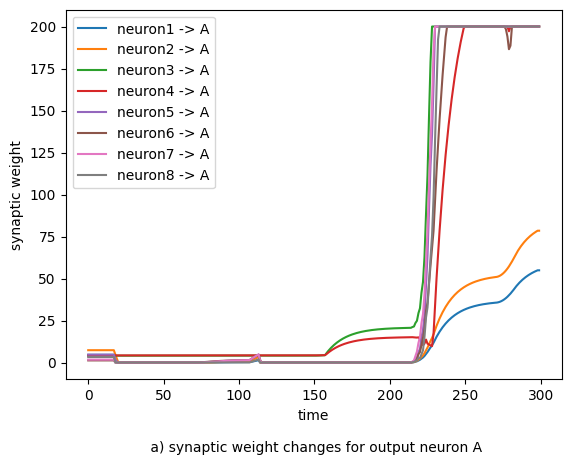

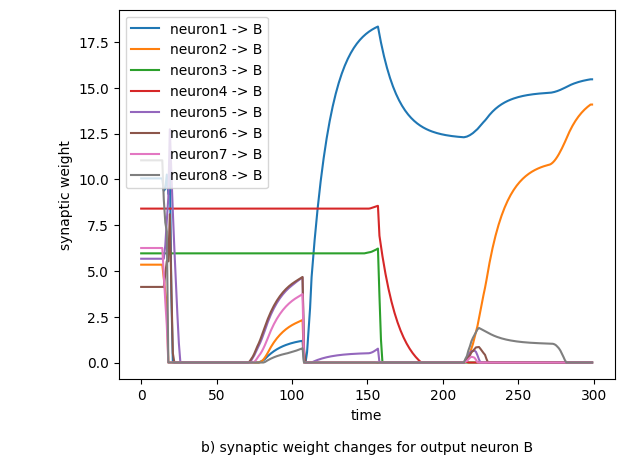

In [122]:
plt.plot(A)
plt.legend(["neuron{} -> A".format(i + 1) for i in range(8)], loc="upper left")
plt.ylabel("synaptic weight")
plt.xlabel("time\n\n a) synaptic weight changes for output neuron A")
plt.show()

plt.plot(B)
plt.legend(["neuron{} -> B".format(i + 1) for i in range(8)], loc="upper left")
plt.ylabel("\n\n\nsynaptic weight")
plt.xlabel("time\n\nb) synaptic weight changes for output neuron B")
plt.show()